In [1]:
import os
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Clustering Models
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

# Classification models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from config import AGE_DICT, SIZE_DICT, TARGET_COLS, BINARY_COLS

In [2]:
HEROKU_URL = os.getenv('HEROKU_POSTGRESQL_AMBER_URL')

uri = HEROKU_URL 
if uri.startswith("postgres://"):
    uri = uri.replace("postgres://", "postgresql://", 1)

In [3]:
# reading data
def read_data():
    df_raw = df_raw = pd.read_sql('petfinder_with_dates', uri)  
    return df_raw

In [4]:
def preprocess_data(df):

    # dropping irrelevant columns
    df = df.drop(columns=["id", "name", "organization_id", "published_at", "status_changed_at", "attribute_declawed", "color_tertiary", "good_with_cats", "good_with_children", "good_with_dogs", "breed_secondary", "color_secondary"])

    # transform "age" column 
    df['age'] = df['age'].map(AGE_DICT).astype(str).astype(int)

    # transform "size" column
    df['size'] = df['size'].map(SIZE_DICT).astype(str).astype(int)

    # dropping unknown values in gender
    df.drop(df[df['gender'] == 'Unknown'].index, inplace=True)

    # Convert binary columns to binary (0/1) data type
    df[BINARY_COLS] = df[BINARY_COLS].astype(bool).astype(int)

    # # Replace 'Male' and 'Female' with 0 and 1, respectively

    # # Replace 'Male' and 'Female' with 0 and 1, respectively, and convert to int
    # df['gender'] = df['gender'].replace({"Male": 0, "Female": 1}).astype(int)

    # Filter data for los 1+
    df = df[df['los'] >= 1]

    # target encoding on larger categorical features
    te = ce.TargetEncoder(cols=TARGET_COLS)
    df[TARGET_COLS] = te.fit_transform(df[TARGET_COLS], df["los"])

    return df


In [5]:
def fill_nan_mode(df, reference_column, feature):
    # Calculate the mode coat for each breed_primary
    mode_by_breed = df.groupby(reference_column)[feature].apply(lambda x: x.mode().iloc[0] if not x.isnull().all() else None)

    # Create a dictionary mapping each breed to its mode coat
    mode_dict = dict(mode_by_breed)

    # Fill the NaN values in 'coat' based on the breed using the mode_dict
    df[feature] = df.apply(lambda row: mode_dict[row[reference_column]] if pd.isna(row[feature]) and row[reference_column] in mode_dict else row[feature], axis=1)

    return df

In [6]:
# Dropping rows with null coat and color primary
def drop_null_rows(df, feature):
    df.dropna(subset=[feature], inplace=True)
    return df

In [7]:
# remove outliers
def remove_outliers(df, columns, zscore_threshold=3):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        z_scores = np.abs((df[col] - mean) / std)
        df = df[z_scores <= zscore_threshold]
    return df

In [8]:
# Read data from the database
df_raw = read_data()

In [9]:
# Preprocess data
df_preprocessed = preprocess_data(df_raw)

In [10]:
# Remove outliers
outlier_columns = ['organization_name', 'los', 'breed_primary']
df_no_outliers = remove_outliers(df_preprocessed, outlier_columns)

In [11]:
df = fill_nan_mode(df_no_outliers, 'breed_primary', 'coat')
df = fill_nan_mode(df_no_outliers, 'breed_primary', 'color_primary')

In [12]:
df = drop_null_rows(df, 'coat')
df = drop_null_rows(df, 'color_primary')

In [13]:
# Rescale data using Standard Scaler for better clustering results
scaler = StandardScaler()
full_data = scaler.fit_transform(df)

/opt/anaconda3/envs/myenv_petfinder/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/myenv_petfinder/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/myenv_petfinder/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/myenv_petfinder/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

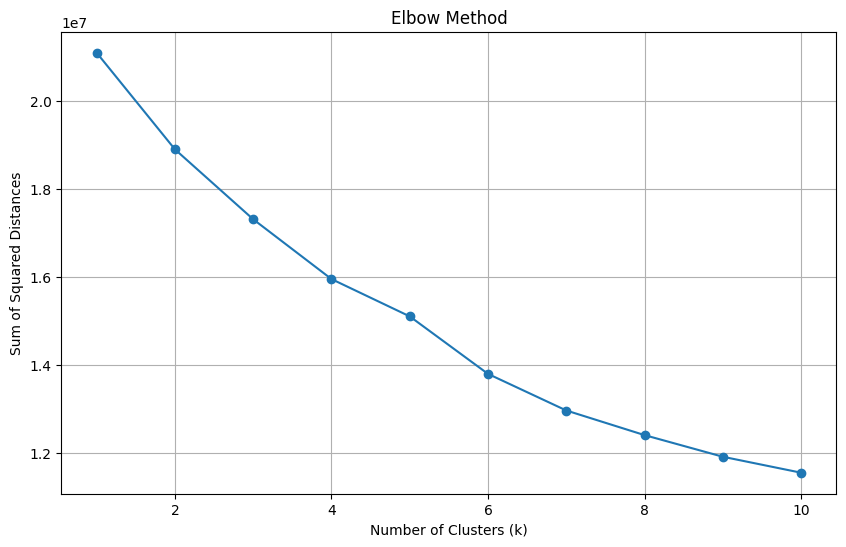

In [14]:
# create a list to store the sum of squared distances for each k
ssd = []

# fit KMeans clustering with different values of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(full_data)
    ssd.append(kmeans.inertia_)

# create a dataframe with the k values and corresponding ssd
df_ssd = pd.DataFrame({'k': range(1, 11), 'ssd': ssd})

# create the line plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df_ssd['k'], df_ssd['ssd'], marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)
plt.show()

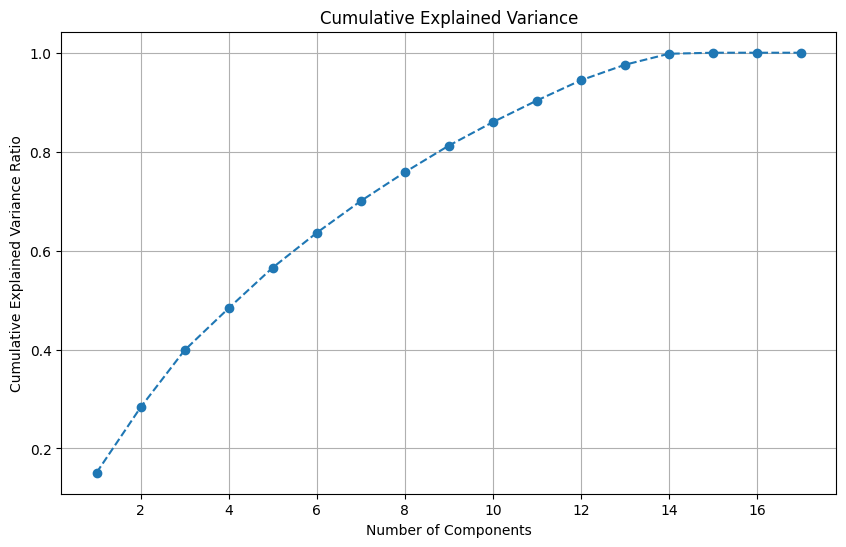

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA without limiting the number of components to see all explained variances
pca = PCA()
pca.fit(full_data)

# Plotting the explained variance
explained_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)
plt.show()

In [16]:
pca = PCA(n_components=14, random_state=42)
df_pca = pca.fit_transform(full_data)

In [17]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(df_pca)
pred = kmeans.predict(df_pca)

/opt/anaconda3/envs/myenv_petfinder/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/opt/anaconda3/envs/myenv_petfinder/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


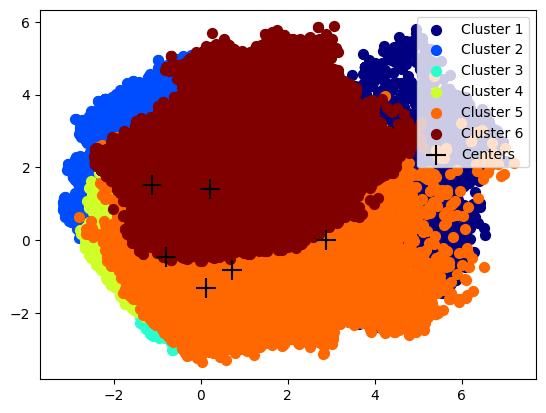

In [18]:
# Determine the number of unique clusters
unique_clusters = np.unique(pred)

# Generate a colormap and pick colors for each cluster
colors = plt.cm.jet(np.linspace(0, 1, len(unique_clusters)))

for i, color in enumerate(colors):
    plt.scatter(df_pca[pred == i, 0], df_pca[pred == i, 1], s=50, c=[color], label=f'Cluster {i+1}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker='+', c='black', label='Centers')
plt.legend()
plt.show()


In [19]:
# Append cluster assignments to the dataframe
df['Cluster'] = pred

# Calculate mean values for each feature by cluster
cluster_means = df.groupby('Cluster').mean()
cluster_medians = df.groupby('Cluster').median()

print(cluster_means)
print(cluster_medians)


                index       age  gender      size        coat  \
Cluster                                                         
0        30805.720119  1.167748     1.0  0.707525  111.879109   
1        90465.985931  1.123254     1.0  1.026702  142.487775   
2        75599.117908  1.530938     1.0  0.972875   78.768628   
3        80093.821964  0.675751     1.0  0.946390   83.846744   
4        76162.367717  1.749274     1.0  0.832311  107.523251   
5        77033.648797  1.083589     1.0  0.995202  215.162918   

         organization_name         los  breed_primary  breed_mixed  \
Cluster                                                              
0               158.094671   66.527415     114.864020     0.689461   
1                77.706221   45.833002     121.017165     0.743239   
2                90.854448   66.279650     123.257255     0.578063   
3                68.905964   31.171303     114.892111     0.882579   
4               112.931074  113.838837     120.084797     0

In [20]:
# Features and target
X = df.drop('Cluster', axis=1) 
y = df['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 99.52%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28627
           1       1.00      1.00      1.00     37720
           2       1.00      0.99      0.99     72154
           3       0.99      1.00      1.00     79987
           4       1.00      1.00      1.00      5675
           5       1.00      0.99      0.99     57098

    accuracy                           1.00    281261
   macro avg       1.00      1.00      1.00    281261
weighted avg       1.00      1.00      1.00    281261

